#Лабораторная работа №2

#Задание 1

Текст задания

Обучить 2 классификатора на основе глубоких нейронных сетей на датасете GTSRB. Использовать следующие модели нейронных сетей: VGG16, ResNet50/10X, MobileNet v2/3. Можно использовать фреймворки Keras, TensorFlow, PyTorch, не надо создавать сети вручную и с нуля. Использовать предобученные сети (например на ImageNet). • Выполнить поиск наилучших гиперпараметров моделей. Использовать бесплатные ресурсы GPU сервиса Google Colab. Составить отчёт: (a) Заполнить Таблицу 1. (b) Для каждой модели построить графики функции потерь для данных валидации и тестирования и графики метрики Accuracy(приер на рис. 2).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Переход в рабочую директорию

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ASZI')  # Укажите путь к вашей рабочей директории
%cd /content/drive/MyDrive/Colab Notebooks/ASZI

Mounted at /content/drive
/content


In [2]:
!pip install adversarial-robustness-toolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.1 MB/s eta 0:00:00


In [3]:
# импортируем необходимые библиотеки
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

Разархивируем датасет, который находится на подключенном гугл диске

In [ ]:
import subprocess
import os

# Путь к архиву
zip_file = '/content/drive/MyDrive/Colab Notebooks/ASZI/archive.zip'

# Распаковка с помощью утилиты unzip
subprocess.run(['unzip', '-q', zip_file, '-d', '/content/drive/MyDrive/Colab Notebooks/ASZI/'])

# Выводим содержимое распакованной директории
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/ASZI/'))


Задаем пути к разархивированным данным

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/ASZI'
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

Прочитаем и выполним предварительную обработку изображений из треннировочного набора данных

In [ ]:
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
# отобразим первый элемент
print("data[0]:\n",data[0])

data[0]:
 [[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         0.92941177]
  [1.         1.         0.9529412 ]
  [1.         1.         0.9764706 ]
  ...
  [0.90588236 0.8156863  0.6901961 ]
  [0.6156863  0.49411765 0.3254902 ]
  [0.34901962 0.33333334 0.24705882]]

 [[1.         1.         0.9411765 ]
  [1.         1.         0.

Отобразим первый элемент в виде картинки

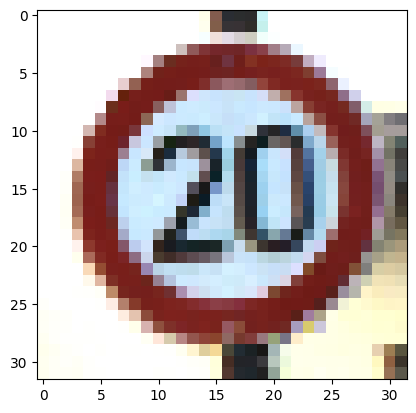

In [ ]:
plt.imshow(data[0])

Выполним разделение данных на треннировочный и тестовый набор 70/30

Так же отобразим размерности обучающего и тестового набора и первый элемент

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)
print(y_train[0])

training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Создаем модель глубокого обучения для классификации изображений (ResNet50)

In [ ]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False
# отобразим итоговую сводку по модели
print(model.summary())

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 43)                11051     
                                                                 
Total params: 24123307 (92.02 MB)
Trainable params: 23545643 (89.82 MB)
Non-trainable params: 577664 (2.20 MB)
____________

Обучаем модель в течение 5 эпох, используем оптимизатор Adam и функцию потерь categorical crossentropy

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# сохраним историю обучения для последующего анализа на графиках
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 72s 72ms/step - loss: 0.9356 - accuracy: 0.7554 - val_loss: 3.6935 - val_accuracy: 0.1495
Epoch 2/5
429/429 [==============================] - 24s 55ms/step - loss: 0.1733 - accuracy: 0.9517 - val_loss: 0.9595 - val_accuracy: 0.7615
Epoch 3/5
429/429 [==============================] - 24s 55ms/step - loss: 0.1294 - accuracy: 0.9667 - val_loss: 1.8382 - val_accuracy: 0.9141
Epoch 4/5
429/429 [==============================] - 23s 54ms/step - loss: 0.1292 - accuracy: 0.9665 - val_loss: 0.1482 - val_accuracy: 0.9564
Epoch 5/5
429/429 [==============================] - 23s 53ms/step - loss: 0.0694 - accuracy: 0.9825 - val_loss: 0.0851 - val_accuracy: 0.9775


Сохраняем модель для последующего использования

In [ ]:
save_model(model, 'ResNet50.h5')

<ipython-input-12-50a5333d5fa8>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'ResNet50.h5')


Считаем данные из csv в датафрейм, в ней содержится оригинальная метка класса и путь к изображению

In [ ]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

По аналогии с предыдущей, создаем модель для классификации изображений (VGG16)

In [ ]:
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False
# отобразим итоговую сводку по модели
print(model2.summary())


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 43)                11051     
                                                                 
Total params: 14857067 (56.68 MB)
Trainable params: 14725739 (56.17 MB)
Non-trainable params: 131328 (513.00 KB)
________

Обучаем модель в течение 5 эпох, используем оптимизатор Adam и функцию потерь categorical crossentropy

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# сохраним историю обучения для последующего анализа на графиках
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 31s 56ms/step - loss: 2.7913 - accuracy: 0.2059 - val_loss: 1.4769 - val_accuracy: 0.4904
Epoch 2/5
429/429 [==============================] - 18s 42ms/step - loss: 0.8810 - accuracy: 0.7008 - val_loss: 0.5477 - val_accuracy: 0.8170
Epoch 3/5
429/429 [==============================] - 18s 43ms/step - loss: 0.3442 - accuracy: 0.8892 - val_loss: 0.3006 - val_accuracy: 0.9012
Epoch 4/5
429/429 [==============================] - 17s 40ms/step - loss: 0.1799 - accuracy: 0.9445 - val_loss: 0.1010 - val_accuracy: 0.9701
Epoch 5/5
429/429 [==============================] - 18s 42ms/step - loss: 0.1717 - accuracy: 0.9523 - val_loss: 0.1138 - val_accuracy: 0.9687


Сохраняем модель для последующего использования

In [ ]:
save_model(model2, 'VGG16.h5')

<ipython-input-16-6f155fe52a71>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model2, 'VGG16.h5')


Выполним оценку производительности дыух моделей на тестовом наборе данных

In [ ]:
history_test = model.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))
history2_test = model2.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))


Epoch 1/5
184/184 [==============================] - 14s 75ms/step - loss: 0.1037 - accuracy: 0.9731 - val_loss: 0.1502 - val_accuracy: 0.9604
Epoch 2/5
184/184 [==============================] - 11s 60ms/step - loss: 0.0955 - accuracy: 0.9775 - val_loss: 0.0871 - val_accuracy: 0.9765
Epoch 3/5
184/184 [==============================] - 13s 69ms/step - loss: 0.0557 - accuracy: 0.9860 - val_loss: 0.0421 - val_accuracy: 0.9873
Epoch 4/5
184/184 [==============================] - 11s 61ms/step - loss: 0.0543 - accuracy: 0.9860 - val_loss: 0.0337 - val_accuracy: 0.9893
Epoch 5/5
184/184 [==============================] - 11s 59ms/step - loss: 0.1478 - accuracy: 0.9718 - val_loss: 24.4470 - val_accuracy: 0.8761
Epoch 1/5
184/184 [==============================] - 11s 60ms/step - loss: 0.1439 - accuracy: 0.9634 - val_loss: 0.0795 - val_accuracy: 0.9765
Epoch 2/5
184/184 [==============================] - 8s 45ms/step - loss: 0.1134 - accuracy: 0.9682 - val_loss: 0.0903 - val_accuracy: 0.9739

Создаем и выводим таблицу, которая показывает точность обоих моделей на треннировочном, валидационном и тестовом наборе данных

In [ ]:
from tabulate import tabulate

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = history_test.history['accuracy']

train_accuracy2 = history2_test.history['accuracy']
val_accuracy2 = history2_test.history['val_accuracy']
test_accuracy2 = history2_test.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)

+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             98.2548 |               97.7472 |         97.1776 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             98.3338 |               99.0479 |         98.3338 |
+----------+---------------------+-----------------------+-----------------+


Строим два графика процесса обучения модели ResNet50 графики отражают зависимость метрики от эпохи для тренировочного и тестового наборов

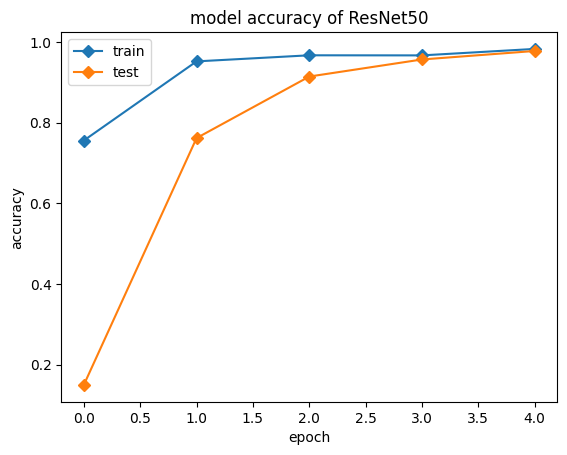

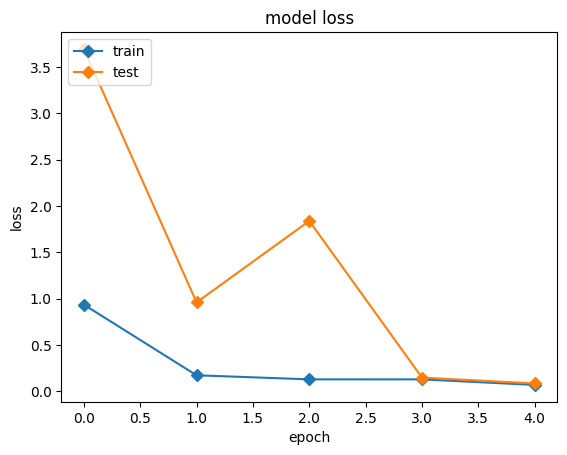

In [ ]:
# график точности
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Визуализируем процесс обучения модели VGG16 аналогично с предыдущим

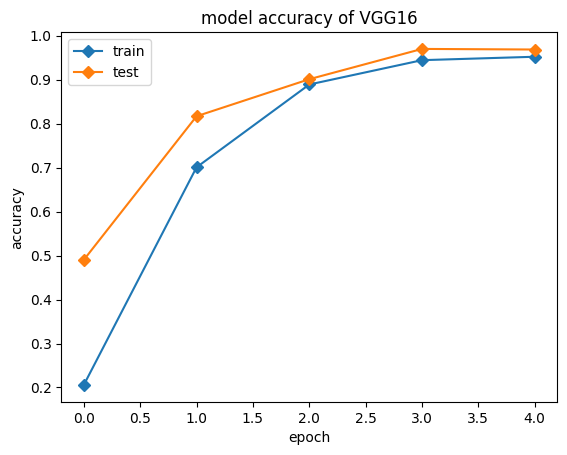

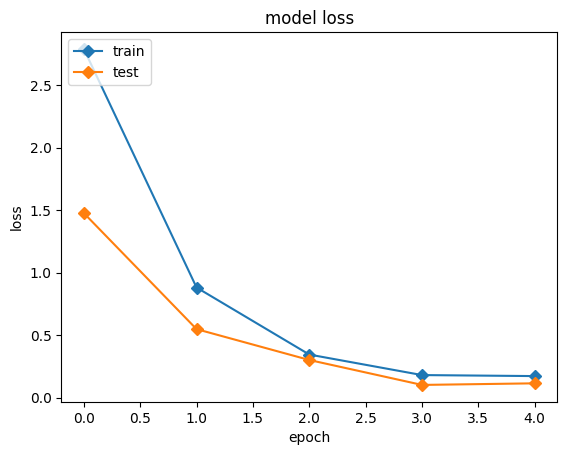

In [ ]:
# график точности
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Как видно из таблицы, модели показывают приблизительно схожие результаты, немного лучше оказалась модель VGG16 (по валидации)

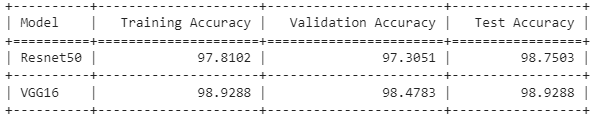

##Задание 2

Текст задания

Применить нецелевую атаку уклонения на основе белого ящика против моделей глубокого обучения. Реализовать следующие типы атак: Fast Gradient Sign Method (FGSM) и Projected Gradient Descent (PGD). Может быть использован код из следующих библиотек: Adversarial Robustness Toolbox ART , Cleverhans CH, scratchai SC. Наиболее проработанная библиотека – Adversarial Robustness Toolbox, рекомендуется использовать её, но другие также могут быть применены. Например, this notebook объясняет как использовать ART с помощью Keras. Также есть другие notebooks с примерами атак на основе библиотеки ART. Используйте атаки FSGM и PGD для создания нецелевых атакующих примеров используя первые 1,000 изображений из тестового множества. Необходимо использовать следующие значения параметра искажения: 𝜖𝜖=[1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]. Постройте графики точности 2-х моделей в зависимости от параметра искажений 𝜖𝜖 (пример на рис. 3, 𝜖𝜖=80/255≈0.3). Для атаки FGSM, отобразите исходное изображение из датасета и атакующее изображение с указанием величины параметра 𝜖𝜖= [1/255, 5/255, 10/255, 50/255, 80/255], отобразите предсказанный класс атакующего изображения (см. рис. 4). Отчёт должен содержать: (a) Заполненную таблицу 2. Все модели должны иметь точность менее 60% для 𝜖𝜖=10/255. (b) Для каждой модели постройте график зависимости точности классификации от параметра искажений 𝜖𝜖 (как на рис. 3). (c) Сделать выводы о полученных результатах.

Загрузим модель из предыдущего задания и берем тысячу первых элементов из тестового множества, создаем классификатор ART

In [ ]:
tf.compat.v1.disable_eager_execution()
# для проведения операций сразу, без
# построения графа вычислений

model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Instructions for updating:
Colocations handled automatically by placer.


Создаем атаку FGSM

In [ ]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_fgsm = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps}) # уствновка нового значения eps
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test) # генерация адверсариальных
    # примеров для тестового набора данных
    loss, accuracy = model.evaluate(x_test_adv, y_test) # оценка потерь и точности
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.2395474348068238
Adv Accuracy: 0.7760000228881836
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.00784313725490196
Adv Loss: 2.312524684906006
Adv Accuracy: 0.6370000243186951
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.011764705882352941
Adv Loss: 3.2741821727752685
Adv Accuracy: 0.5040000081062317
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.01568627450980392
Adv Loss: 4.066489070892334
Adv Accuracy: 0.42500001192092896
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.0196078431372549
Adv Loss: 4.716347549438477
Adv Accuracy: 0.35600000619888306
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.03137254901960784
Adv Loss: 6.036895011901856
Adv Accuracy: 0.22699999809265137
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.0392156862745098
Adv Loss: 6.497013877868652
Adv Accuracy: 0.19099999964237213
True Loss: 0.319371736347675

Сохраним атаку FGSM для дальнейшего анализа

In [ ]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


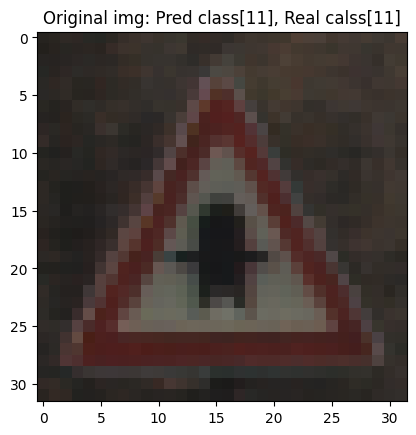

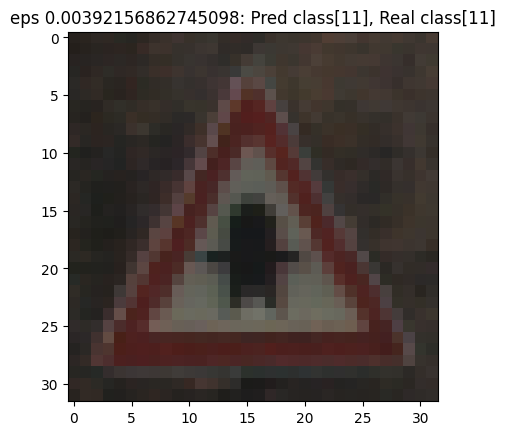

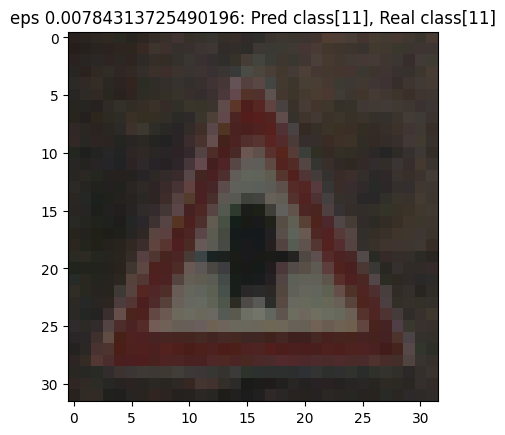

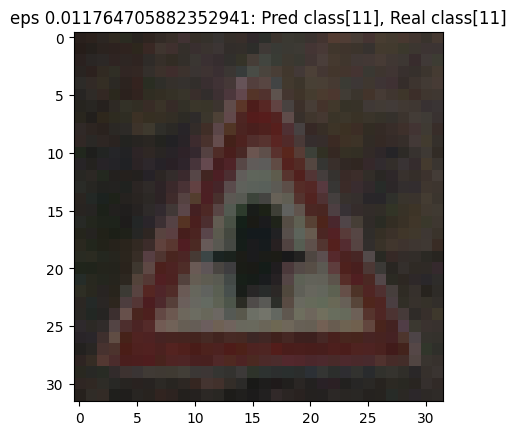

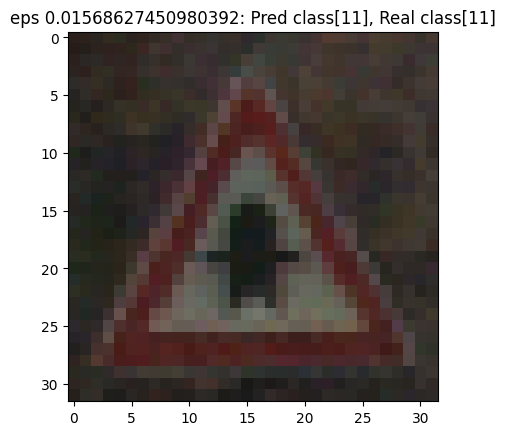

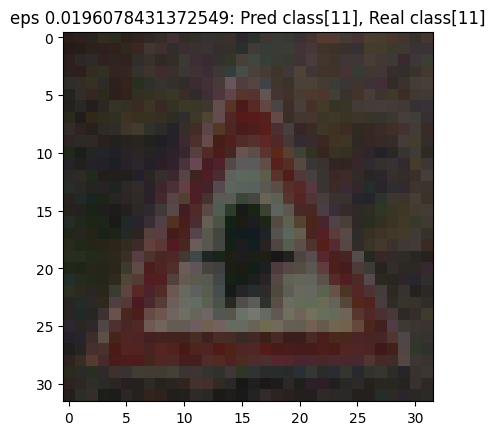

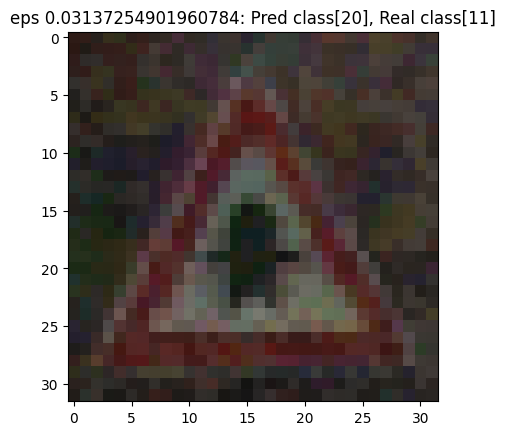

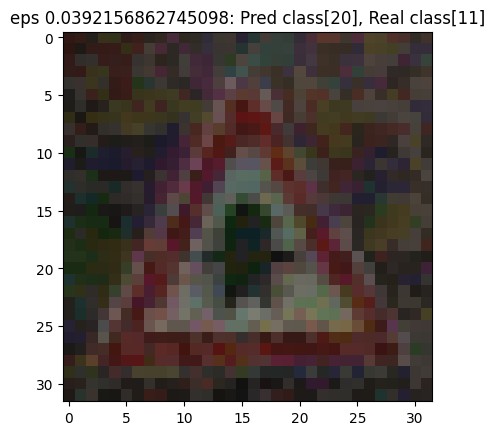

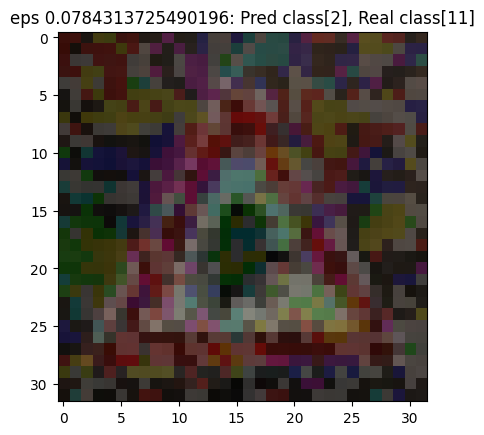

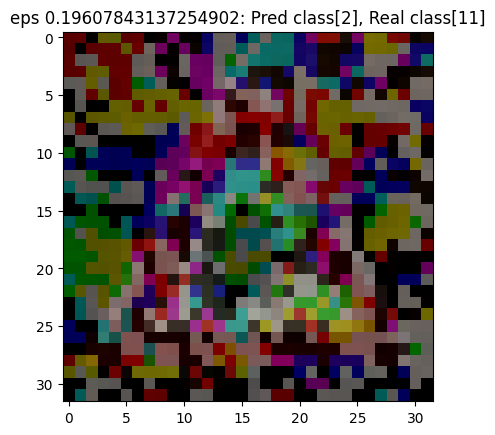

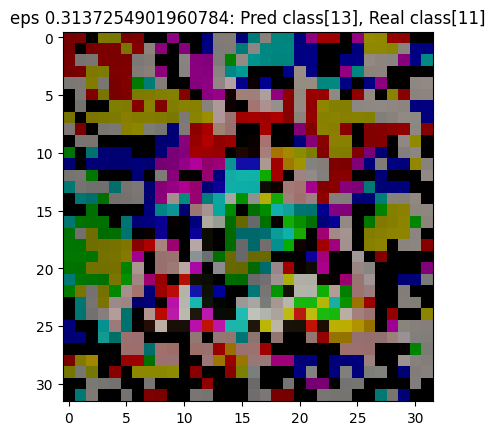

In [ ]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Как видно, ошибки предсказания из-за наложенного шума начались со значения 2/225

Теперь реализуем атаку PGD для той же модели, создаем атаку по аналогии с предыдущей

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Создаем атаку PGD

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_pgd = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.5310148062705993
Adv Accuracy: 0.7429999709129333
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.00784313725490196
Adv Loss: 2.9217974004745484
Adv Accuracy: 0.5740000009536743
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.011764705882352941
Adv Loss: 4.20118741607666
Adv Accuracy: 0.460999995470047
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.01568627450980392
Adv Loss: 5.1723936119079585
Adv Accuracy: 0.3790000081062317
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.0196078431372549
Adv Loss: 5.937147785186768
Adv Accuracy: 0.3199999928474426
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.03137254901960784
Adv Loss: 6.9078956298828125
Adv Accuracy: 0.25699999928474426
True Loss: 0.31937173634767535
True Accuracy: 0.9229999780654907
Eps: 0.0392156862745098
Adv Loss: 7.085444694519043
Adv Accuracy: 0.25600001215934753
True 

Сохраним атаку PGD для дальнейшего анализа с помощью графика

In [ ]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)


Отображаем исходные и адверсариальные изображения для разных значений eps

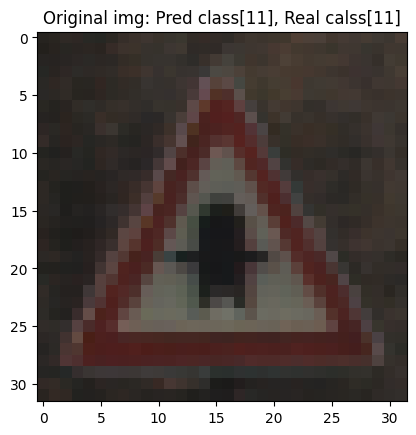

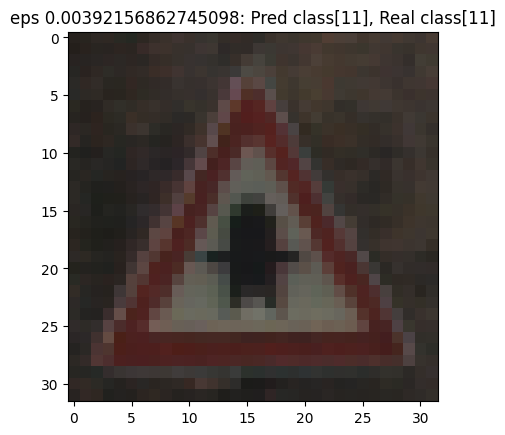

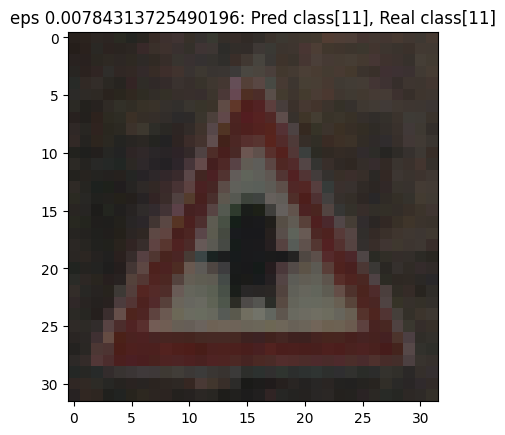

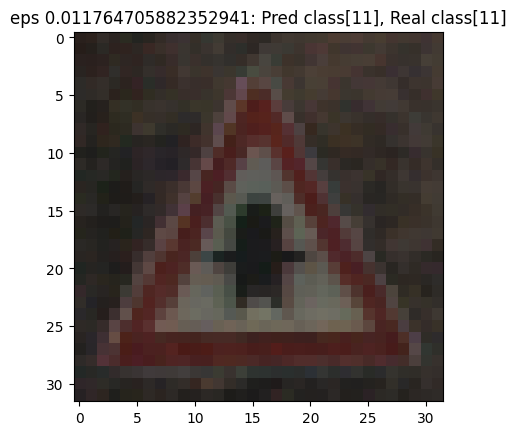

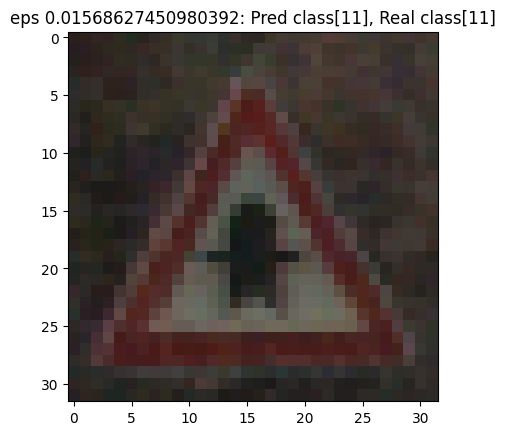

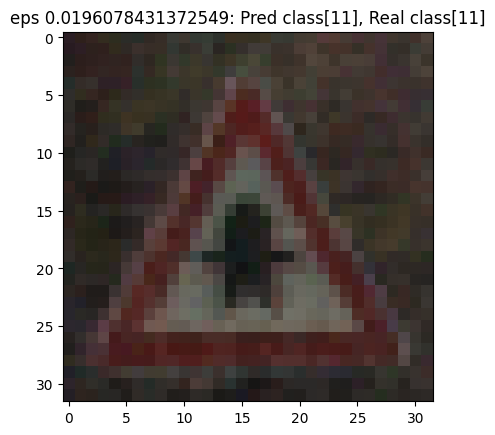

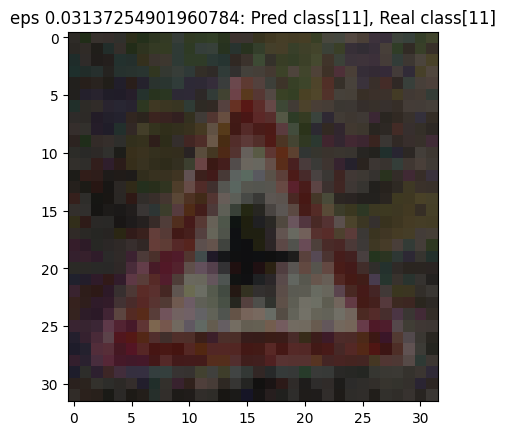

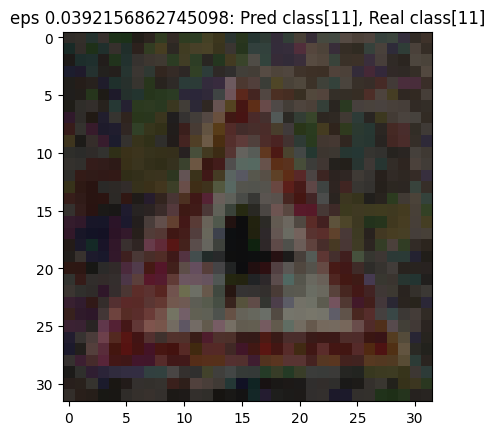

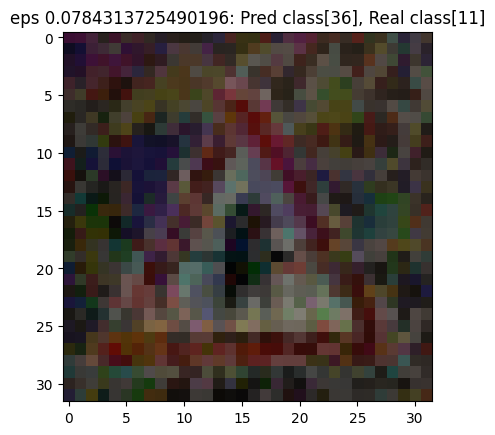

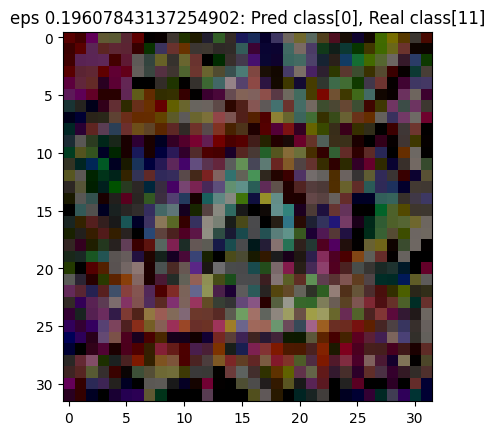

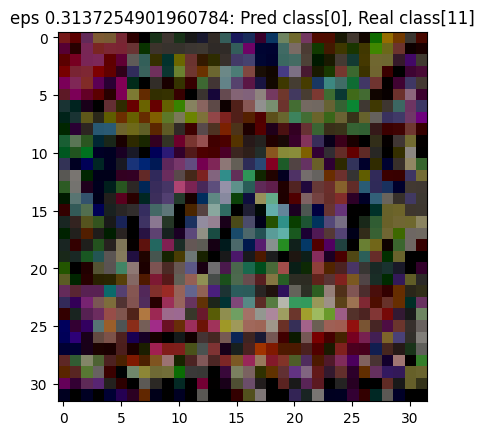

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Предсказания стали ложными при параметре 2/255

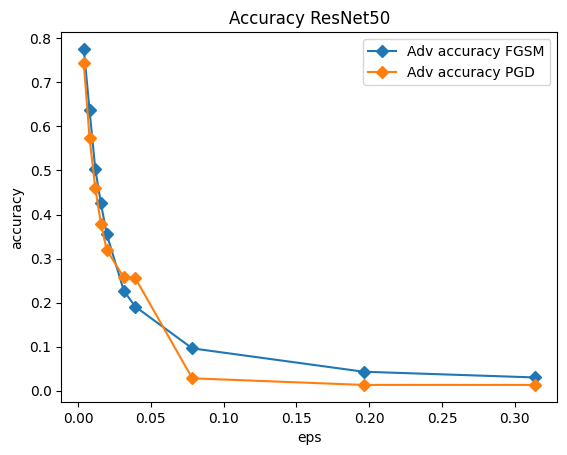

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# загружаем ранее сохраненный массив адвирсариальных точностей для атак FGSM и PDG
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_ResNet50.npy")
# строим график зависимости адверсариальной точности от значения eps для атак PDG и FGSM
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy ResNet50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Проделаем аналогичные атаки для VGG16 реализуем атаку FGSM для модели VGG16, которую сохраняли в первом задании

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Создаем атаку FGSM по аналогии с VGG16

In [ ]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_fgsm = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.9639461345672607
Adv Accuracy: 0.8220000267028809
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.00784313725490196
Adv Loss: 1.6841323413848877
Adv Accuracy: 0.6919999718666077
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.011764705882352941
Adv Loss: 2.3033039436340332
Adv Accuracy: 0.5989999771118164
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.01568627450980392
Adv Loss: 2.862193826675415
Adv Accuracy: 0.5189999938011169
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.0196078431372549
Adv Loss: 3.397426597595215
Adv Accuracy: 0.453000009059906
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.03137254901960784
Adv Loss: 4.562106740951538
Adv Accuracy: 0.35600000619888306
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.0392156862745098
Adv Loss: 5.102621585845947
Adv Accuracy: 0.3070000112056732
True L

Сохраним атаку FGSM для дальнейшего анализа с помощью графика

In [ ]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_VGG16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_VGG16", adv_accuracises_fgsm)

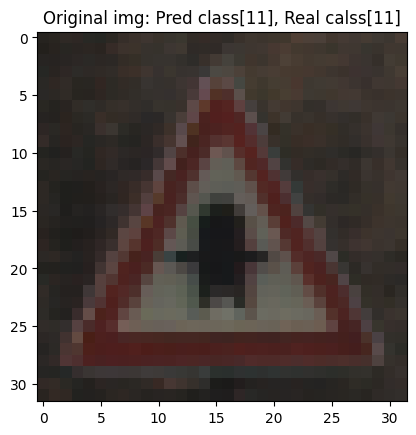

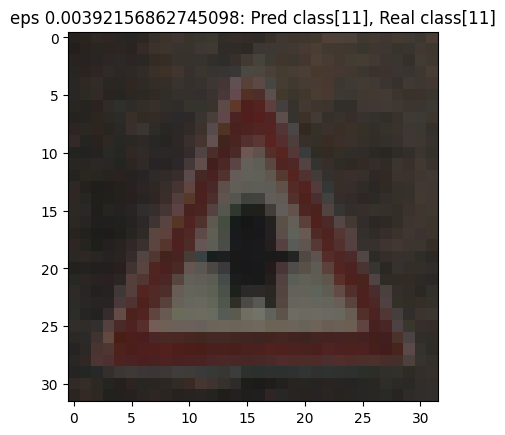

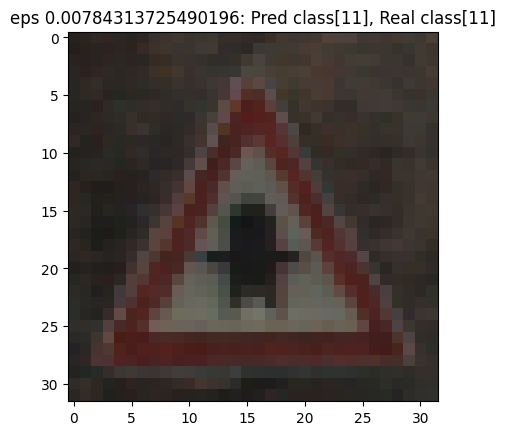

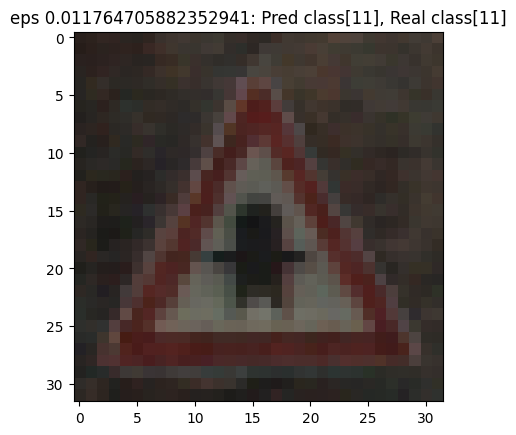

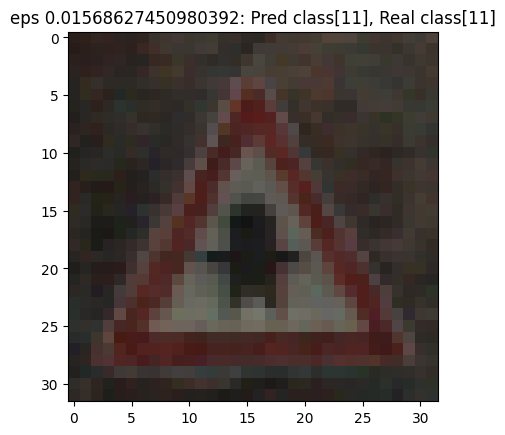

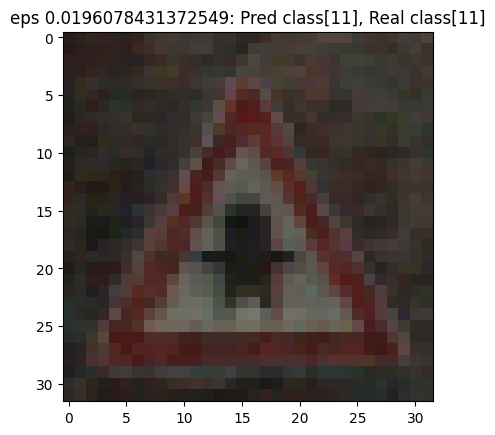

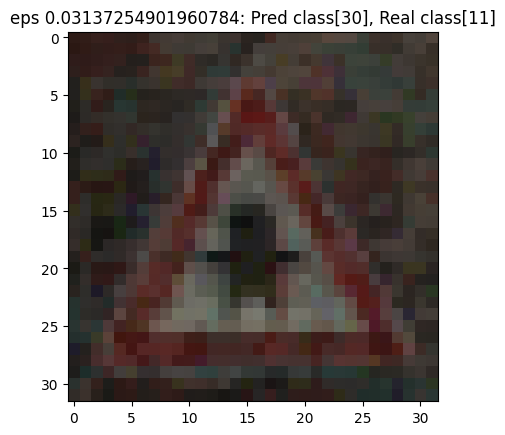

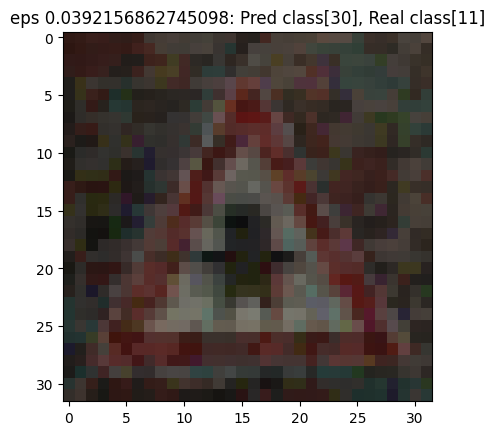

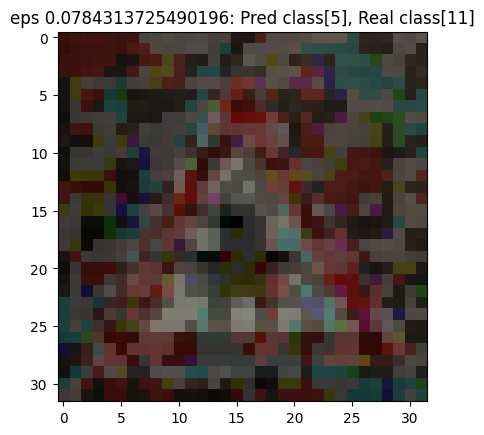

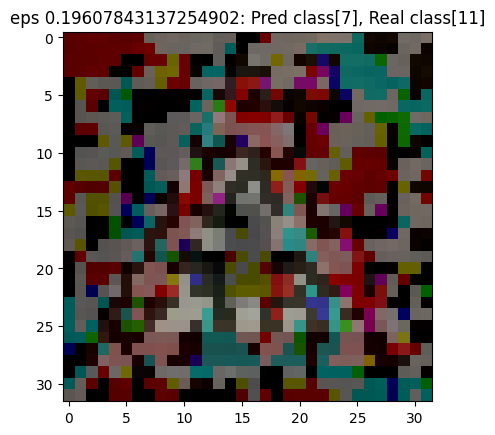

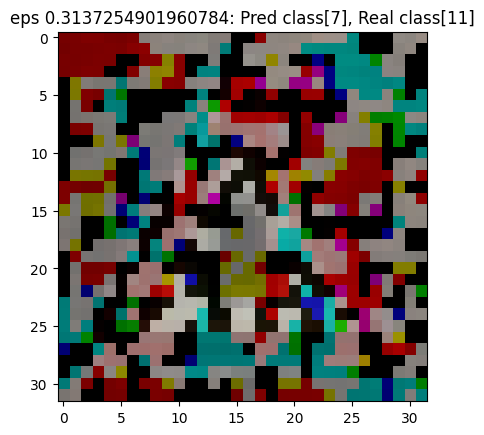

In [ ]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Был выдан ложный результат при значении eps 8/255.



Реализуем атаку PGD для модели VGG16

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Создаем атаку PGD по аналогии с ResNet50

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_pgd = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.1266095838546752
Adv Accuracy: 0.7850000262260437
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.00784313725490196
Adv Loss: 2.013786449432373
Adv Accuracy: 0.6600000262260437
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.011764705882352941
Adv Loss: 2.825141689300537
Adv Accuracy: 0.5659999847412109
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.01568627450980392
Adv Loss: 3.4736587009429933
Adv Accuracy: 0.4869999885559082
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.0196078431372549
Adv Loss: 4.197357696533203
Adv Accuracy: 0.46799999475479126
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.03137254901960784
Adv Loss: 5.561800703048706
Adv Accuracy: 0.35199999809265137
True Loss: 0.30725688877701757
True Accuracy: 0.9350000023841858
Eps: 0.0392156862745098
Adv Loss: 5.9277546539306645
Adv Accuracy: 0.3199999928474426
True

Сохраним атаку PGD для дальнейшего анализа с помощью графика

In [ ]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

Отображаем исходные и адверсариальные изображения для разных значений eps

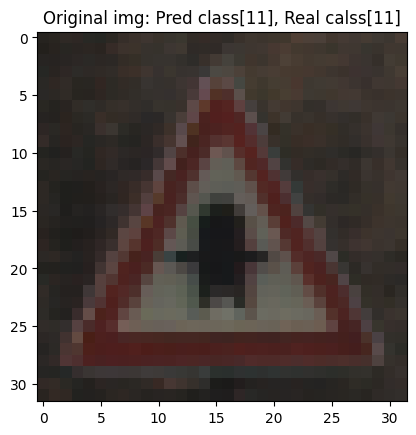

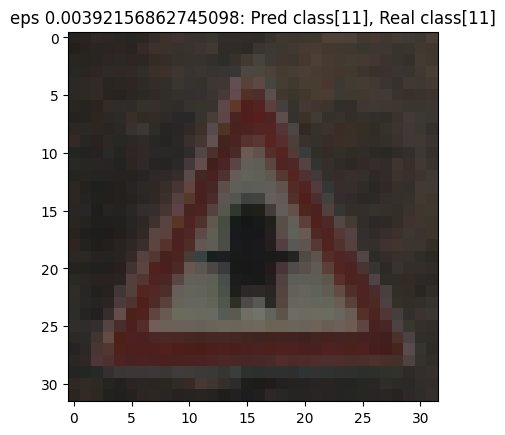

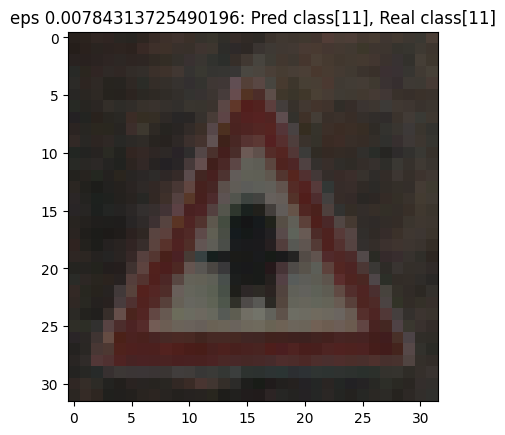

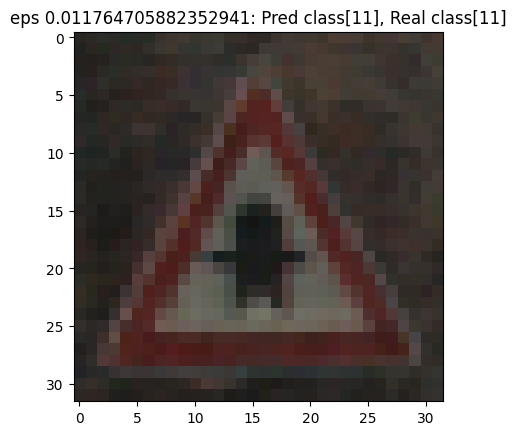

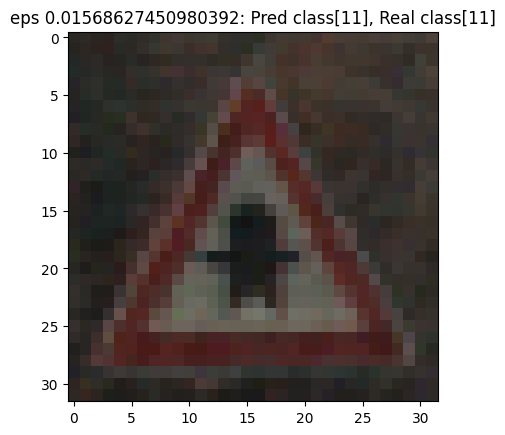

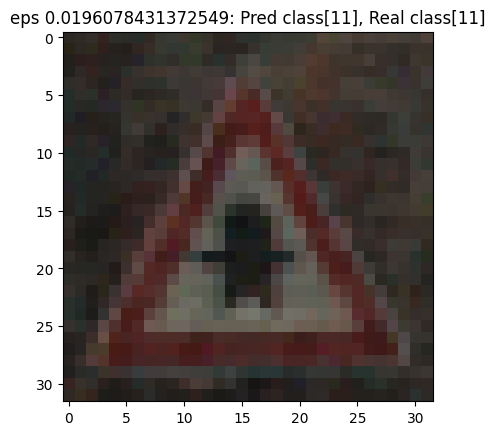

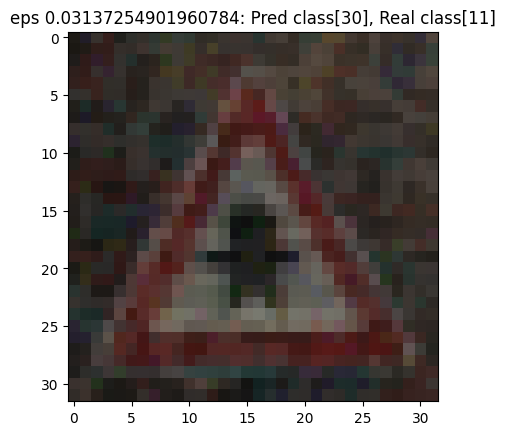

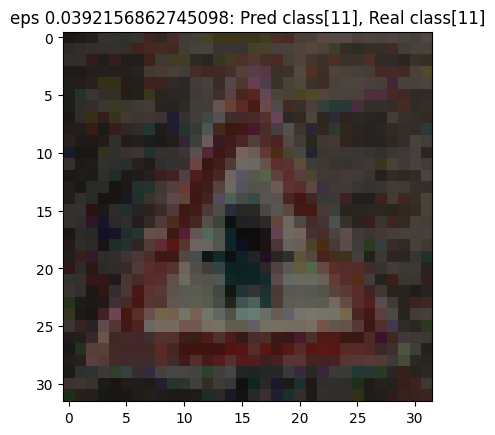

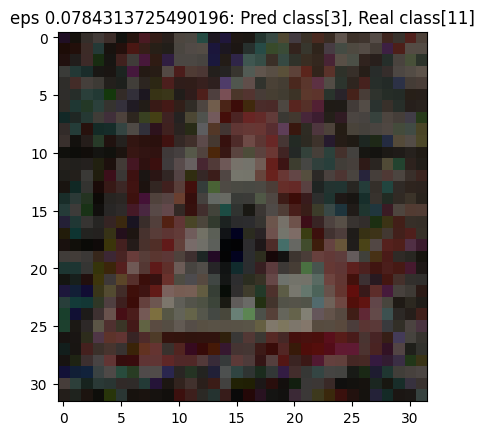

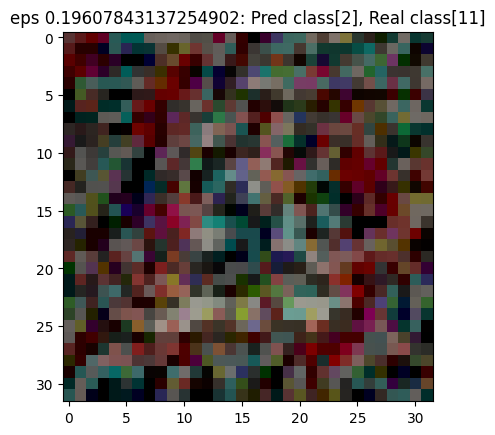

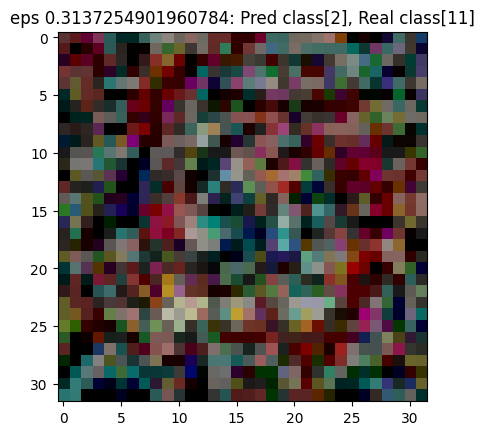

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Ошибка предсказания произошла при значении eps 4/255.

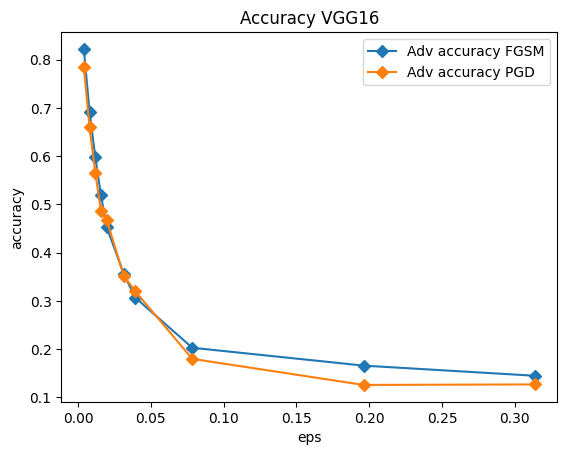

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# загружаем ранее сохраненный массив адвирсариальных точностей для атак FGSM и PGD
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
# строим график зависимости адверсариальной точности от значения eps для атак PGD и FGSM
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

В случае VGG6, при атаках PGD и FGSM точность сначала падает одинаково, но с повышением значений eps в какой-то момент точнотсть при атаке PGD начинает падать сильнее, но при максимальном значении eps точность сильнее всего упала при атаке FGSM.

In [ ]:
# eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# создадим таблицу со значениями точности для обеих моделей
adv_acc_fgsm_rn50 = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_acc_pgd_rn50 = np.load("adv_accuracises_pgd_ResNet50.npy")
adv_acc_fgsm_v16 = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_acc_pgd_v16 = np.load("adv_accuracises_pgd_VGG16.npy")

table = [["Model","Original accuracy","eps = 1/255","eps = 2/255", "eps = 3/255", "eps = 4/255", "eps = 5/255", "eps = 8/255", "eps = 10/255", "eps = 20/255", "eps = 50/255", "eps = 80/255" ],
            ["Resnet50 FGSM",train_accuracy[4]*100,adv_acc_fgsm_rn50[0]*100,
             adv_acc_fgsm_rn50[1]*100,adv_acc_fgsm_rn50[2]*100,adv_acc_fgsm_rn50[3]*100,
             adv_acc_fgsm_rn50[4]*100,adv_acc_fgsm_rn50[5]*100,adv_acc_fgsm_rn50[6]*100,
             adv_acc_fgsm_rn50[7]*100,adv_acc_fgsm_rn50[8]*100,adv_acc_fgsm_rn50[9]*100],
            ["Resnet50 PGD",train_accuracy[4]*100,adv_acc_pgd_rn50[0]*100,
             adv_acc_pgd_rn50[1]*100,adv_acc_pgd_rn50[2]*100,adv_acc_pgd_rn50[3]*100,
             adv_acc_pgd_rn50[4]*100,adv_acc_pgd_rn50[5]*100,adv_acc_pgd_rn50[6]*100,
             adv_acc_pgd_rn50[7]*100,adv_acc_pgd_rn50[8]*100,adv_acc_pgd_rn50[9]*100],
            ["VGG16 FGSM",train_accuracy2[4]*100,adv_acc_fgsm_v16[0]*100,
             adv_acc_fgsm_v16[1]*100,adv_acc_fgsm_v16[2]*100,adv_acc_fgsm_v16[3]*100,
             adv_acc_fgsm_v16[4]*100,adv_acc_fgsm_v16[5]*100,adv_acc_fgsm_v16[6]*100,
             adv_acc_fgsm_v16[7]*100,adv_acc_fgsm_v16[8]*100,adv_acc_fgsm_v16[9]*100],
            ["VGG16 PGD",train_accuracy2[4]*100,adv_acc_pgd_v16[0]*100,
             adv_acc_pgd_v16[1]*100,adv_acc_pgd_v16[2]*100,adv_acc_pgd_v16[3]*100,
             adv_acc_pgd_v16[4]*100,adv_acc_pgd_v16[5]*100,adv_acc_pgd_v16[6]*100,
             adv_acc_pgd_v16[7]*100,adv_acc_pgd_v16[8]*100,adv_acc_pgd_v16[9]*100],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+
| Model         |   Original accuracy |   eps = 1/255 |   eps = 2/255 |   eps = 3/255 |   eps = 4/255 |   eps = 5/255 |   eps = 8/255 |   eps = 10/255 |   eps = 20/255 |   eps = 50/255 |   eps = 80/255 |
+===============+=====================+===============+===============+===============+===============+===============+===============+================+================+================+================+
| Resnet50 FGSM |             98.2548 |          77.6 |          63.7 |          50.4 |          42.5 |          35.6 |          22.7 |           19.1 |            9.6 |            4.3 |            3   |
+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------

Таким образом была отражена таблица для всех показанных атак и моделей.
По таблице видно, что точность выше при всех значениях eps у модели VGG16.

Задание 3

Создадим две целевых атаки

Загружаем тестовый набор данных из Test.csv и извлекаем изображения с меткой 14

Преобразуем изображения в массив чисел и нормализуем

In [ ]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

Реализуем целевую атаку FGSM

Сгенерируем адверсариальные примеры и оценим точность модели на них и на исходных тестовых данных

In [ ]:
model=load_model('ResNet50.h5')
tf.compat.v1.disable_eager_execution()
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 0.4769917669119658
Adv Accuracy: 0.8962963223457336
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.00784313725490196
Adv Loss: 1.6361143271128336
Adv Accuracy: 0.7185184955596924
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.011764705882352941
Adv Loss: 2.8242157247331408
Adv Accuracy: 0.4962962865829468
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.01568627450980392
Adv Loss: 4.305968415295636
Adv Accuracy: 0.27037036418914795
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.0196078431372549
Adv Loss: 5.603105099995931
Adv Accuracy: 0.13703703880310059
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.03137254901960784
Adv Loss: 7.318789153628879
Adv Accuracy: 0.018518518656492233
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.0392156862745098
Adv Loss: 7.659855153825548
Adv Accuracy: 0.011111111380159855
True Loss: 0.019071

Тут эксперементируем со значениями eps для достижения наилучшего резултата.

Лучше всего себя показывает 10/255

In [ ]:
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

Отобразим 5 разных изображений для визуализации действия атаки

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


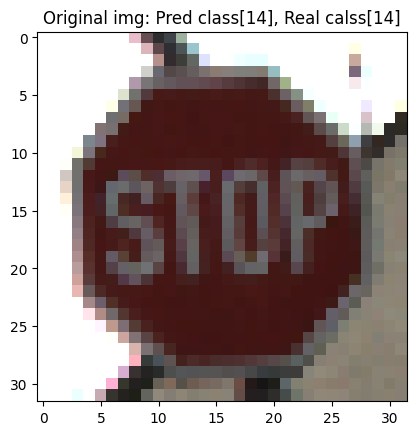

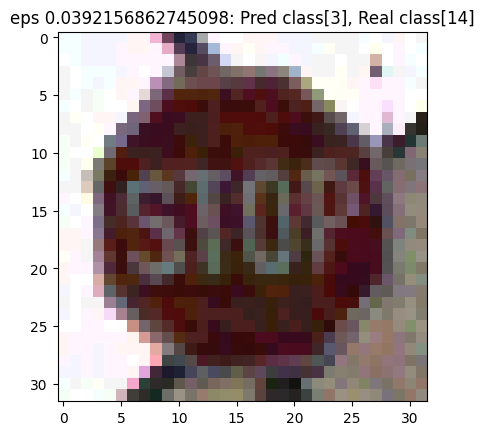

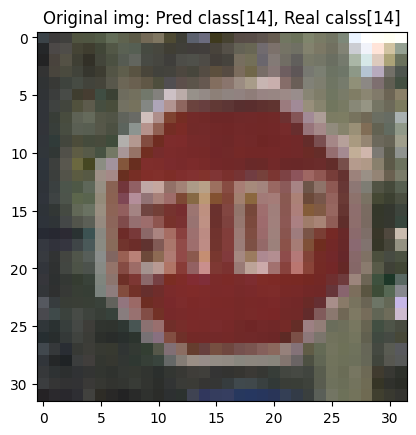

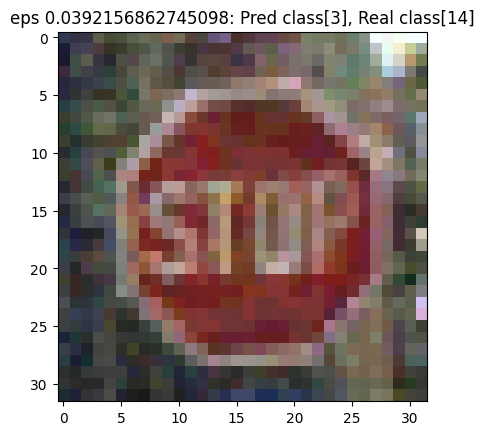

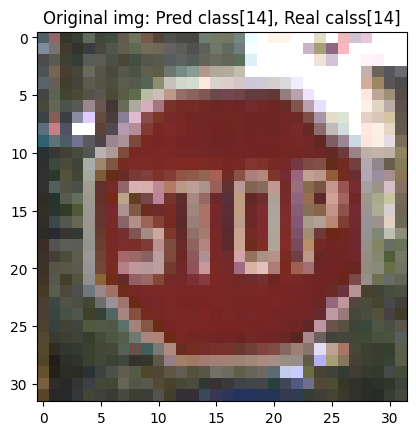

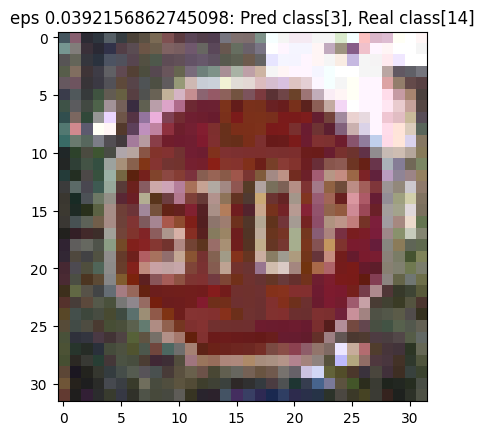

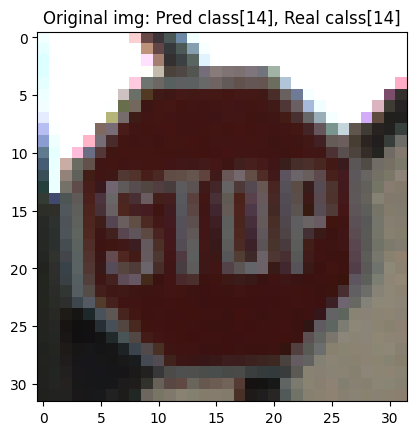

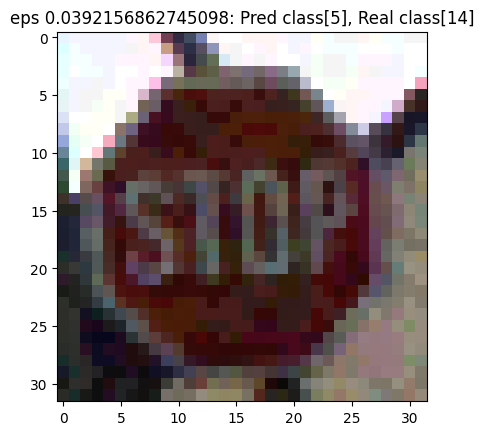

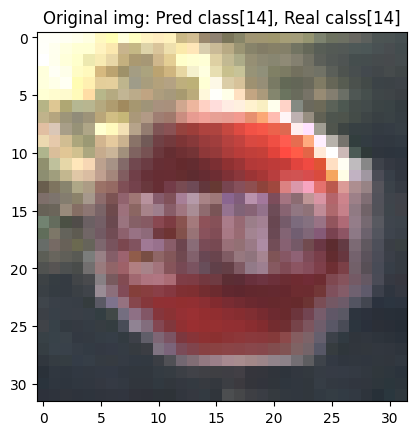

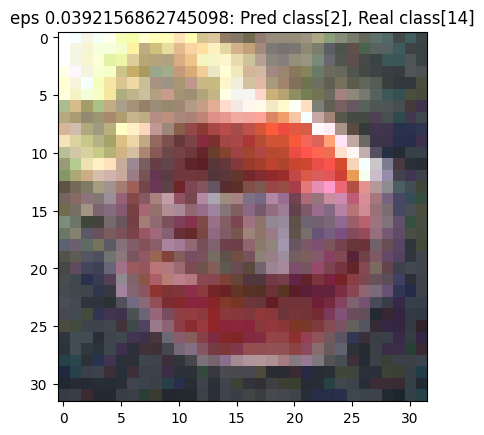

In [ ]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

Целевая атака FGSM достигает своего пика на eps = 10/255 в нашем случе, при больших значениях eps атака хоть и будет давать больше неточности при предсказании, но это будут разные классы, в большинстве случаев отличные от первого (знак стоп), который мы указали. Можно сделать вывод, что FGSM не очень подходит для целевых атак.

Реализуем целевую атаку PGD

Сгенерируем адверсариальные примеры и оценим точность модели на адвирсариальных примерах и на исходных тестовых данных

In [ ]:
model=load_model('ResNet50.h5')
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.25476389941242006
Adv Accuracy: 0.9518518447875977
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.00784313725490196
Adv Loss: 0.7215891098534619
Adv Accuracy: 0.8814814686775208
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.011764705882352941
Adv Loss: 1.3723015908841734
Adv Accuracy: 0.7555555701255798
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.01568627450980392
Adv Loss: 1.6586463654482806
Adv Accuracy: 0.6851851940155029
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.0196078431372549
Adv Loss: 1.8076372358534072
Adv Accuracy: 0.6925926208496094
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.03137254901960784
Adv Loss: 2.1138581072842633
Adv Accuracy: 0.699999988079071
True Loss: 0.019071308437614114
True Accuracy: 0.9962962865829468
Eps: 0.0392156862745098
Adv Loss: 2.508257579803467
Adv Accuracy: 0.61851853132247

In [ ]:
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

Отобразим 5 разных изображений для визуализации действия атаки

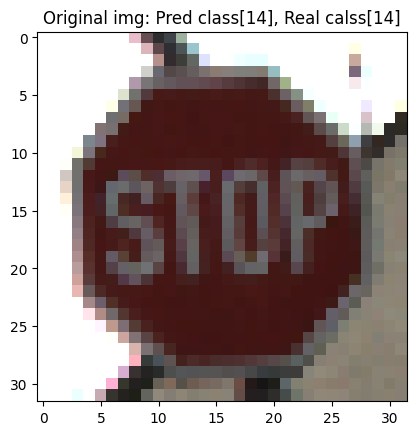

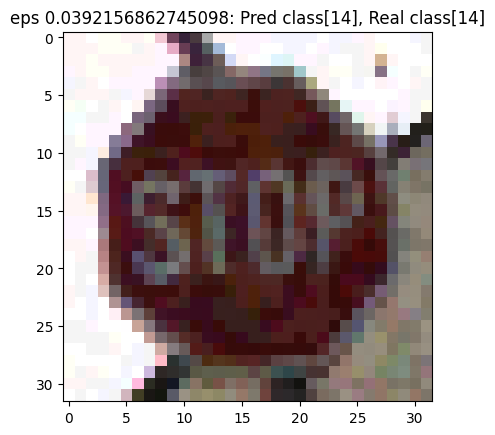

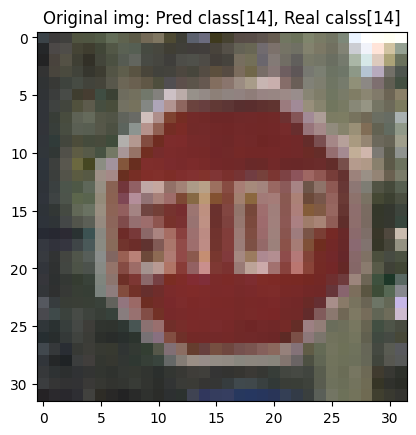

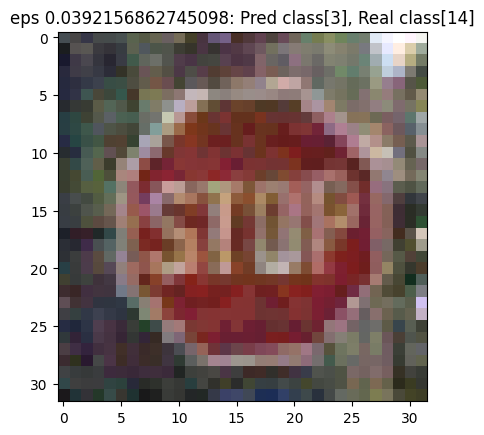

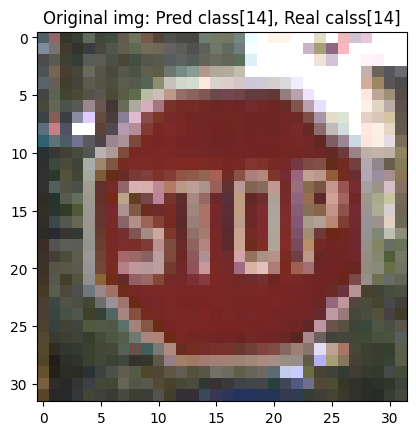

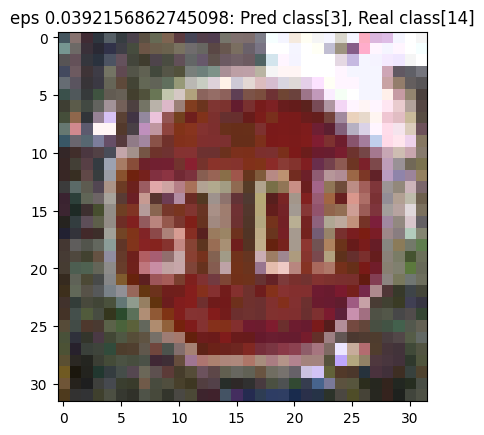

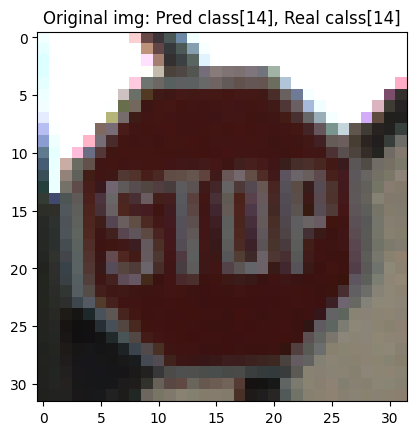

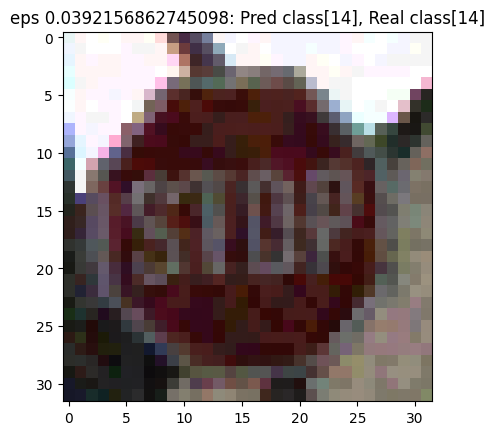

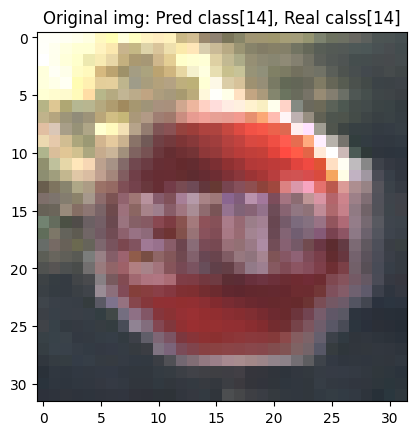

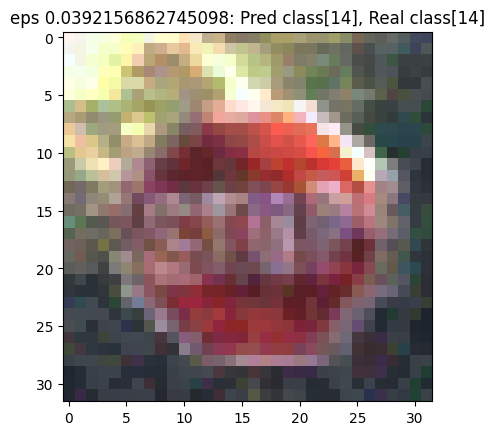

In [ ]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

Атака PGD достигает отличных значений при eps 50/255, при таком значении очень много требуемых результатов.

Как видим, атака PGD дольше сохранеяет точность, чем FGSM. При этом PGD намного лучше подходит для целевых атак, так как на больших значениях eps выдает лучший требуемый (класс 1 - знак стоп) результат, чем FGSM.